# An example with a dense network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import sys

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

import numpy as np

sys.path.append("../")


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 1. Define a network.

In [2]:
import convex_adversarial

netSplit = convex_adversarial.DenseSequential(
    convex_adversarial.Dense(nn.Sequential()),
    convex_adversarial.Dense(nn.Linear(2,3)), 
    convex_adversarial.Dense(nn.Linear(2,4), None),
    convex_adversarial.Dense(nn.Linear(4,4)),
    convex_adversarial.Dense(nn.Linear(3,4), None, nn.Linear(4,4)),
    convex_adversarial.Dense(nn.Linear(4,5)),
)

## 2. Define an example

In [3]:
# random points at least 2r apart
m = 20
np.random.seed(3)
x = [np.random.uniform(size=(2))]
y = []
r = 0.1
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
        if np.random.chisquare(2)<1.0:
            y.append(1)
        else:
            y.append(0)

# Remove the first element from x, as it does not have a classification
x = x[1:]
 
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
Y = torch.Tensor(np.array(y)).long()


## 3. Learn the network

In [4]:
torch.manual_seed(123)
iterations = 30000
opt = optim.Adam(filter(lambda p: p.requires_grad,netSplit.parameters()), lr=1e-3)
# opt = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
for i in range(iterations):
    out = netSplit(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(Y))
    err = (out.max(1)[1].data != Y).float().mean()
    if i % (iterations // 10) == 0:
        print(l.data.item(), err.item())
    opt.zero_grad()
    (l).backward()
    opt.step()
print(l.data.item())

1.5260834693908691 0.42105263471603394
0.6256595849990845 0.31578946113586426
0.625626266002655 0.31578946113586426
0.6256230473518372 0.31578946113586426
0.6256225109100342 0.31578946113586426
0.6256235241889954 0.31578946113586426
0.6256220936775208 0.31578946113586426
0.6256219148635864 0.31578946113586426
0.6256219744682312 0.31578946113586426
0.625622034072876 0.31578946113586426
0.6256219744682312


## 4. Visualize the network

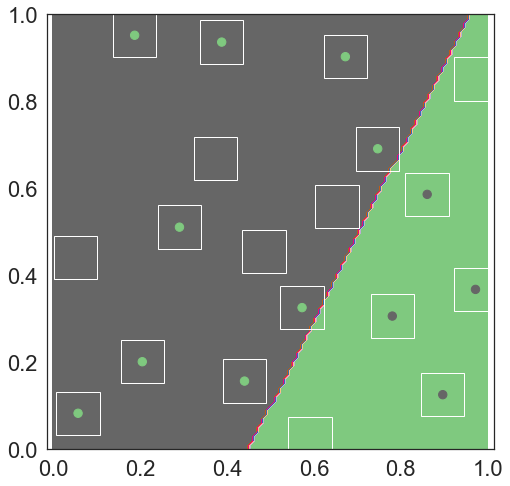

In [5]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = netSplit(X0)

ZZ = (np.argmax(np.stack([y0[:,a].detach().numpy() for a in range(0,y0.size()[1])]),axis=0))
ZZ.resize(100,100)

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="Accent")
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=Y.numpy(), cmap="Accent", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))


## 5. Robust learning

In [6]:
from convex_adversarial import robust_loss

data = []
torch.manual_seed(123)
opt = optim.Adam(filter(lambda p: p.requires_grad,netSplit.parameters()), lr=1e-3)
for i in range(2000):
    robust_ce, robust_err = robust_loss(netSplit, epsilon, Variable(X), Variable(Y))
    out = netSplit(Variable(X))
    l2 = nn.CrossEntropyLoss()(out, Variable(Y))
    err = (out.max(1)[1].data != Y).float().mean()
    data.append([l2.data.item(), robust_ce.data.item(), err, robust_err])
    if i % 100 == 0:
        print(i,robust_ce.data.item(), robust_err)
    opt.zero_grad()
    (robust_ce).backward()
    opt.step()
print(l2.data.item(), robust_ce.data.item(), robust_err)

AttributeError: 'int' object has no attribute 'dim'

## 6. Visualize Network -- Robust Version

In [ ]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = netSplit(X0)

ZZ = (np.argmax(np.stack([y0[:,a].detach().numpy() for a in range(0,y0.size()[1])]),axis=0))
ZZ.resize(100,100)

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="Accent")
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=Y.numpy(), cmap="Accent", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))
